# MultiVariate Time Series Usecase with LSTM encoder decoder model

## Use Case: Predciting individual household electric power consumption.

Data Set can be downloaded from [here](http://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf


### Loading Dataset

<div style="align:justify">
The downloaded 'household_power_consumption.txt' text file contains electric consumption records seperated by semicolon. Also we can see in the text file that it has two seperate columns 'Date' and 'Time'. I will parse these two features into a single feature 'Date_Time' and will make it as an index of the dataset.
</div>

In [2]:
energy_data = pd.read_csv('household_power_consumption.txt',
                          sep=';',
                          infer_datetime_format=True,
                          parse_dates={'Date_Time':[0,1]},
                          index_col='Date_Time')
energy_data.info()

C:\Users\Hasher\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    object 
 1   Global_reactive_power  object 
 2   Voltage                object 
 3   Global_intensity       object 
 4   Sub_metering_1         object 
 5   Sub_metering_2         object 
 6   Sub_metering_3         float64
dtypes: float64(1), object(6)
memory usage: 126.7+ MB


Dataset has 2075529 records of electric consumptions by household. There are 7 columns in the dataset of type 'object'. Lets fetch first 5 records and see.

In [3]:
energy_data.head(5)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Date_Time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


First thing as dataset description says that it has missing records indiacted by caharacter '?', hence i will first replace this character with NaN so that i can later replace missing values easily. Dataset has records of every minutes starting from 16th Dec, 2006.

### Data Preprocessing

In [4]:
energy_data.replace('?',np.nan, inplace=True)

In the dataset i can see that all values are numeric, hence i will convert column types from 'object' to 'float32'.

In [5]:
energy_data = energy_data.astype('float32')

#### Missing Value Treatment:
Lets check counts of missing values in the dataset.

In [6]:
energy_data.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

There are 25979 records with no values. Those needs to be handled. Lets write a function to handle those missng numbers. The function will replace missing value by its previous days value at the same time. For e.g if the missing value is at 12 o'clock on 16th Jan then i will replace this missing value with value at 12 o'clock on 15th Jan.

In [7]:
def fill_missing(data):
    prev_day = 24 * 60
    for r in range(data.shape[0]):
        for c in range(data.shape[1]):
            if np.isnan(data[r,c]):
                data[r,c] = data[r - prev_day, c]
    

In [8]:
fill_missing(energy_data.values)

In [9]:
energy_data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

There are no more missing values present in the dataset.  

I will now create a new feature 'Sub_metering_4' which is nothing but power consumptions from other areas in household than mentioned areas.

In [10]:
energy_data['Sub_metering_4'] = (energy_data['Global_active_power'] * 1000/60) - (energy_data['Sub_metering_1'] + energy_data['Sub_metering_2'] + energy_data['Sub_metering_3']) 

In [11]:
energy_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Date_Time,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.839996,18.4,0.0,1.0,17.0,52.266670
2006-12-16 17:25:00,5.360,0.436,233.630005,23.0,0.0,1.0,16.0,72.333336
2006-12-16 17:26:00,5.374,0.498,233.289993,23.0,0.0,2.0,17.0,70.566666
2006-12-16 17:27:00,5.388,0.502,233.740005,23.0,0.0,1.0,17.0,71.800003
2006-12-16 17:28:00,3.666,0.528,235.679993,15.8,0.0,1.0,17.0,43.099998


Lets save the preprocessed data into pickle file so that i can later refer to this pickle file rather running previous tasks again.

In [12]:
energy_data.to_pickle('energy_data_preprocessed.pkl')

### Patterns in Observations Over Time

In a timeseries problem , next step is analysing the pattern of data. Best way to analyse is drawing line plot of data for different measures.

Lets draw line plot for each features in the dataset

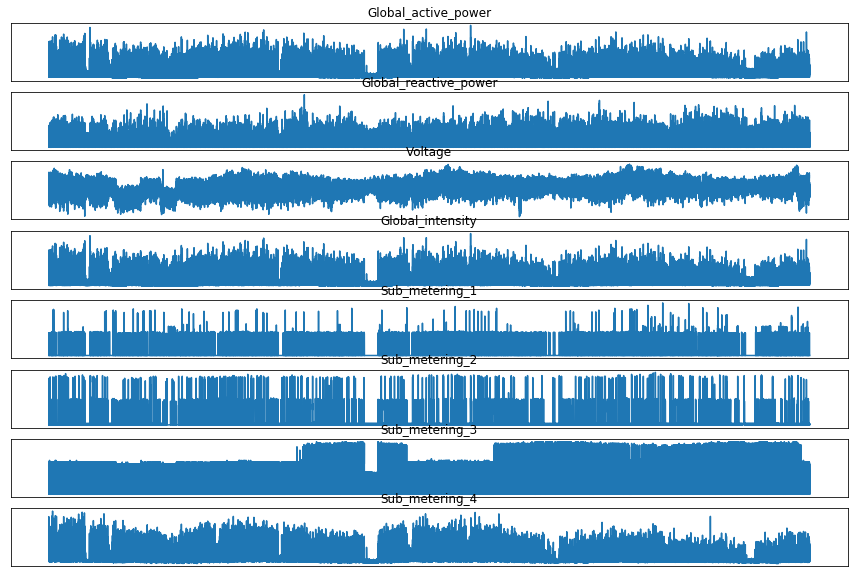

In [13]:
plt.figure(figsize=(15,10))
cols = len(energy_data.columns)
for i in range(cols):
    plt.subplot(cols, 1, i+1)
    plt.plot(energy_data.iloc[:,i])
    plt.title(energy_data.columns[i])
    plt.xticks([])
    plt.yticks([])

No such patterns can be observed from above high level line plots of features. Lets examine target variable 'Global_active_power' for all years.

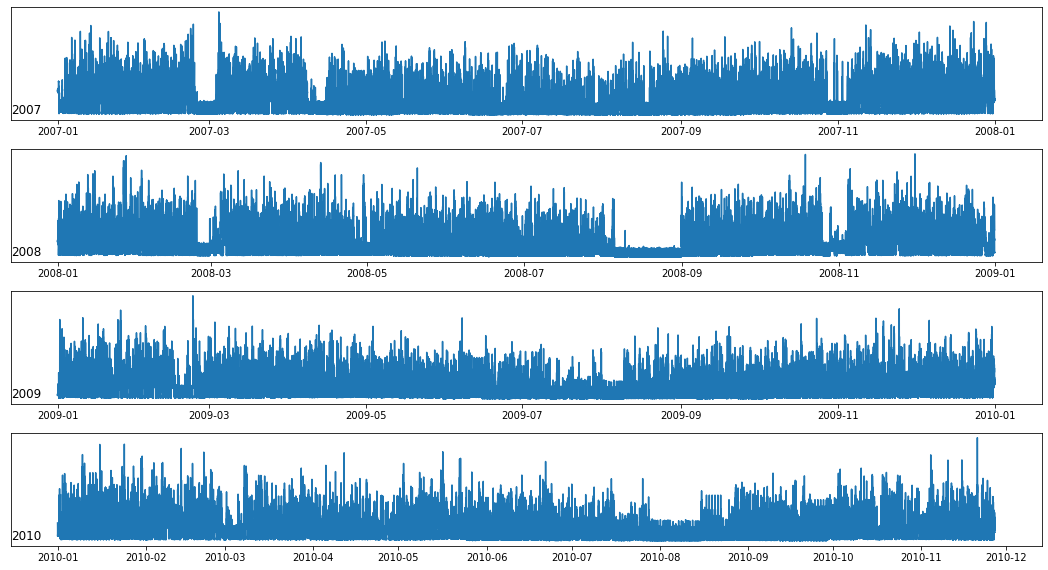

In [14]:
# Line Plot of 'Global_Active_Power' year wise
years = ['2007','2008','2009','2010']
plt.figure(figsize=(15,8))
for i in range(len(years)):
    plt.subplot(len(years), 1, i+1)
    plt.plot(energy_data[years[i]]['Global_active_power'])
    plt.title(years[i], y=0, loc='left')
    plt.tight_layout(True)
    
    plt.yticks([])

i can see in the above plots, between march-april and july-agust electric consumption is lower in all years. And also starting and ending days of eavry year there are more power consumptions.  

Lets analyse electric consumption on monthly basis. For simplicity i will just analyse for year 2007.

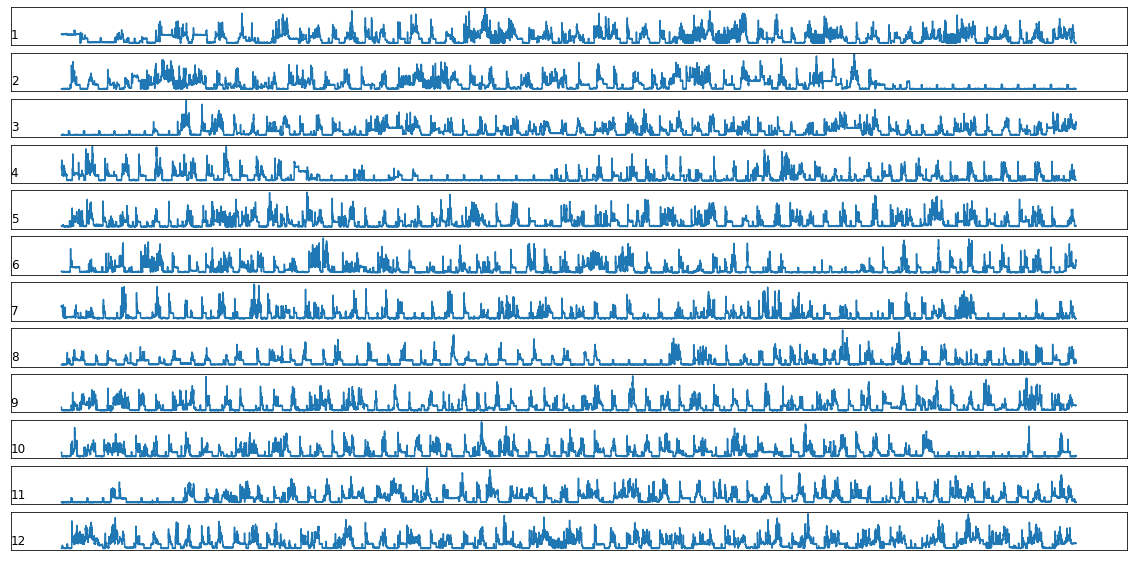

In [15]:
months = list(range(1, 13))
plt.figure(figsize=(20,10))
for i in range(len(months)):
    plt.subplot(len(months), 1, i+1)
    plt.plot(energy_data['2007-'+ str(months[i])]['Global_active_power'])
    plt.title(months[i], loc='left', y=0)
    plt.xticks([])
    plt.yticks([])


I can understand from above monthwise consumption plots that,  
1. End of February and Start of March has less consumption of electricity.
2. Half of the August month has less electric consumption.
3. Most power consumption in November, December and January months.  

We can check for other years too to see if the same pattern follows in other years also. But for the time being i am moving ahead with data distribution.

### Time Series Data Distributions

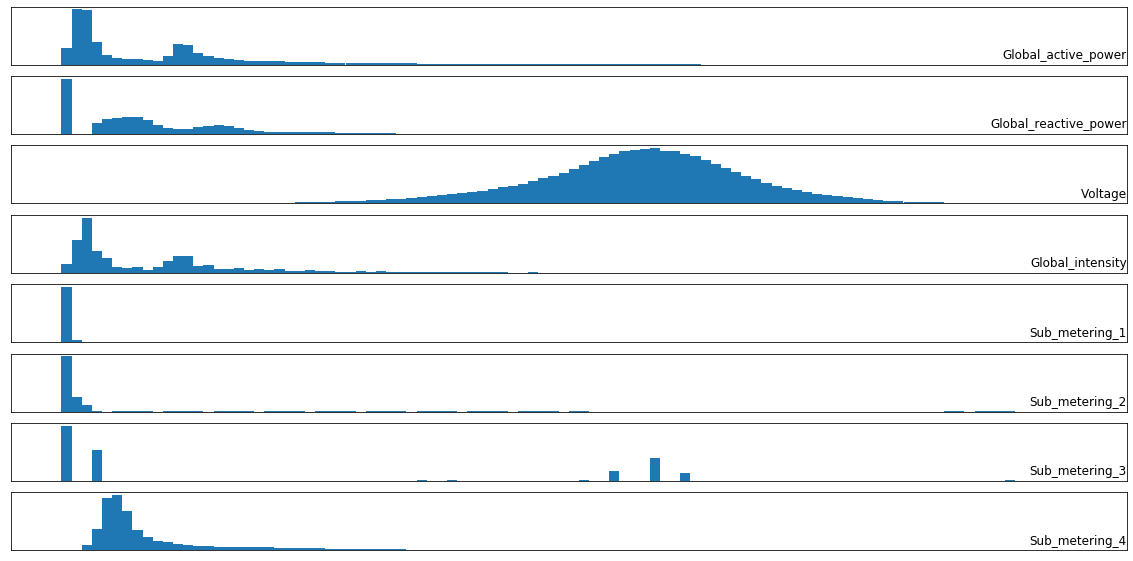

In [16]:
plt.figure(figsize=(20,10))
for i in range(len(energy_data.columns)):
    plt.subplot(len(energy_data.columns), 1, i+1)
    energy_data[energy_data.columns[i]].hist(bins=100)
    plt.title(energy_data.columns[i], loc='right', y =0)
    plt.xticks([])
    plt.yticks([])

Look at distribution plot of feature 'Voltage' , it is pwrfectly following Gaussian distribution. And other features are assymetric in nature. Even features like 'sub_metering_3' , 'Global_Intensity' etc has two groups of distribution meaning having two different means.  

These kind of data analysis will help us to frame the problem and to find out insights from buisness point of view. We can create many more visuals with different settings to understand the data better.

Now let me go ahead with prediction. So after understanding data , i have framed same prediction usecase in two different ways as below,  
1. Lets try predicting next day electric consumtipn given the previous seven days data.
2. Lets try to predict next hour electric consumption given previous 24 hours of data.  

This is how a time series problem can be framed for prediction/classification. There can be many other possible ways to frame same problem. I will try above two options.

### Option 1: Predicting Next Day Consumption , given previous 7 days consumption data  

So if i provide Day1 to Day7 data then model should predict Day8 electric consumption. Lets go ahead.

First step i would take is splitting dataset into training and testing set.

#### Feature Engineering 

Plan is to provide previous 7 days data. In my dataset i have already seen it contains every minute data. So i will add each minute's data to get a single day data. This can be done by resampling dataset by day.

In [17]:
# Resampling Minute Data to total for each day
daily_data = energy_data.resample('D').mean()
print('Shape of Data Minute Wise ', daily_data.shape)
print('Shape of Data Day Wise ', daily_data.shape)

daily_data.to_csv('daily_household_power_consumption.csv')

Shape of Data Minute Wise  (1442, 8)
Shape of Data Day Wise  (1442, 8)


So there i get 1442 days of records after resampling. 

In [18]:
daily_data.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
Date_Time,,,,,,,,
2006-12-16,3.053475,0.088187,236.243759,13.082829,0.000000,1.378788,12.439394,37.073063
2006-12-17,2.354486,0.156949,240.087021,9.999028,1.411806,2.907639,9.264584,25.657408
2006-12-18,1.530435,0.112356,241.231689,6.421667,0.738194,1.820139,9.734722,13.214190
2006-12-19,1.157079,0.104821,241.999313,4.926389,0.582639,5.279167,4.303472,9.119375
2006-12-20,1.545658,0.111804,242.308060,6.467361,0.000000,1.838889,9.765972,14.156111


Next i will correlation between features. Since all are numeric features i will use correlation coefficient to check colinearity.

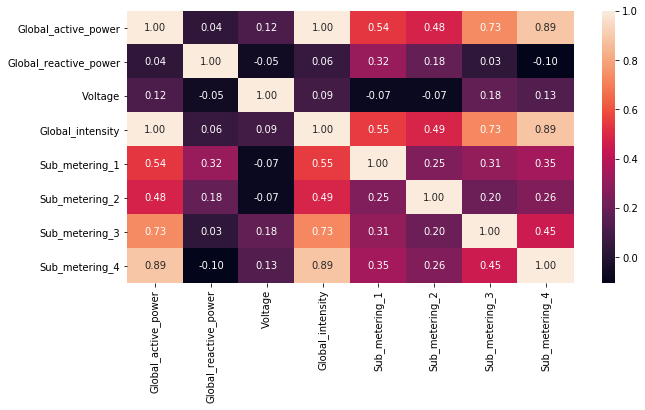

In [19]:
plt.figure(figsize=(10,5))
sns.heatmap(daily_data.corr(), annot=True, fmt='.2f')
plt.show()

In the above heatmap can see non of the features has correlation value greater than 0.9 among themselves. So no multicolinearity exists in the dataset when i sample data daywise. Even vidualise the relationship of dependent features with independent variable.

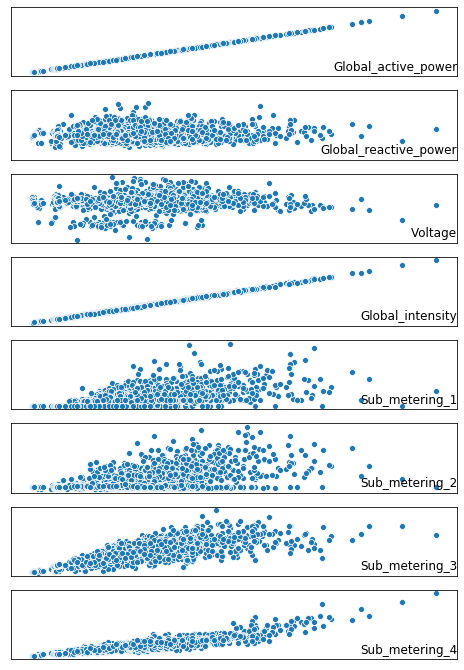

In [20]:
plt.figure(figsize=(8,12))
for i in range(8):
    plt.subplot(8, 1, i+1)
    sns.scatterplot(data=daily_data, x='Global_active_power', y=daily_data.columns[i])
    plt.title(daily_data.columns[i], loc='right', y =0)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
plt.show()   

Even from above scatterplot it is clear that feature 'Global_Intensity' is strong positively related to target variable. Features 'Voltage' and 'Global_reactive_power' has no linear relation with target variable. Features 'Sub_metering_3' and 'Sub_metering_4' has positive linear reltionship with target variable. Features 'Sub_metering_1' and 'Sub_metering_2' has moderate linear relationship with target variable.  

Lets observ the statistics of features.

In [21]:
daily_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,1.090413,0.123667,240.834000,4.622686,1.117891,1.291090,6.451773,9.312793
std,0.417962,0.033849,2.044201,1.730959,1.098398,1.447814,2.555913,4.279574
min,0.173818,0.057811,231.088226,0.808333,0.000000,0.000000,0.894444,1.606690
25%,0.816802,0.099349,240.095783,3.510694,0.486111,0.301563,4.645313,6.528310
50%,1.073969,0.118888,240.957939,4.544306,0.778125,0.484722,6.443403,8.774097
75%,1.318014,0.140659,241.863445,5.534236,1.528993,1.897222,8.174826,11.457460
max,3.314851,0.290163,247.435013,14.028055,7.762500,8.409028,16.488194,42.872524


#### Feature Scaling and Transformation  

As i have seen in the distribution plot of features that there are features which are not normally distributed. And also in the data statistics table i can understand feature scaling is needed for bettrt model performence. Hence i would apply feature transformationd and feature scaling on features.  

Lets write a common function which will scale feature usning 'MinMaxScaling' methodology.

In [22]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
def scaleFeatures(data):
    scaler = MinMaxScaler()
    return scaler.fit_transform(data) 

###### ...Global_intensity  

Let me first check the original distribution of the feature.

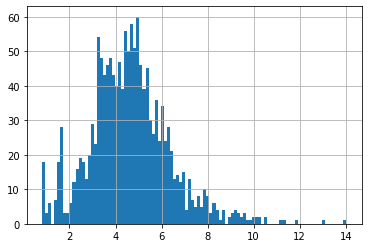

In [23]:
daily_data.Global_intensity.hist(bins=100)

It looks feature distribution is right skeweed and also range is between 1100 and 20000. So i will first transform feature into close enough of normal distribution then will perform MinMaxScaler on the feature to bring it within a smaller range.

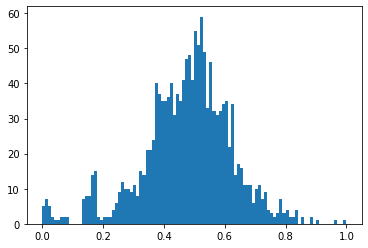

In [24]:
gi = daily_data.Global_intensity**(1/3)
scaled_gi = scaleFeatures(gi.values.reshape(-1,1))
plt.hist(x= scaled_gi, bins=100)
plt.show()

Now the feature is close to normal distribution and also range is within 0 to 1. Lets try the techniques to other features aswell.

###### ...Sub_metering_3

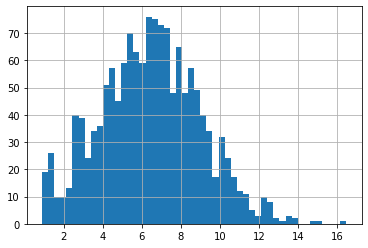

In [25]:
# Original Distribution
daily_data.Sub_metering_3.hist(bins=50)

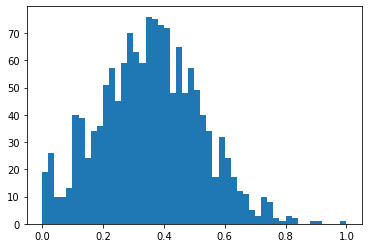

In [26]:
sbm3 = daily_data.Sub_metering_3
scaled_sbm3 = scaleFeatures(sbm3.values.reshape(-1,1))
plt.hist(x= scaled_sbm3, bins=50)
plt.show()

###### ... Sub_metering_4

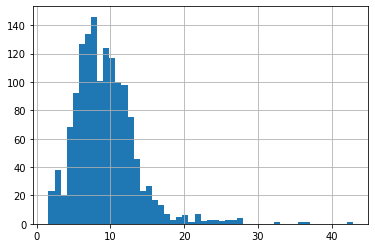

In [27]:
# Original Distribution
daily_data.Sub_metering_4.hist(bins=50)

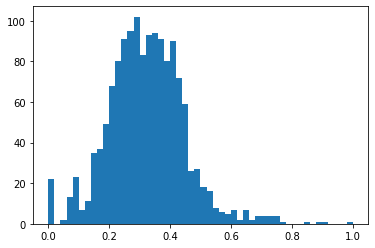

In [28]:
sbm4 = daily_data.Sub_metering_4**(1/2)
scaled_sbm4 = scaleFeatures(sbm4.values.reshape(-1,1))
plt.hist(x= scaled_sbm4, bins=50)
plt.show()

###### ...Global_reactive_power

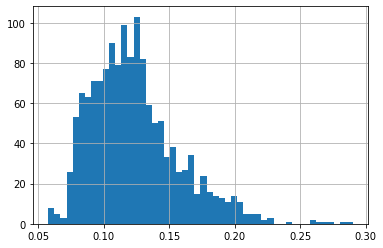

In [29]:
# Original Distribution
daily_data.Global_reactive_power.hist(bins=50)

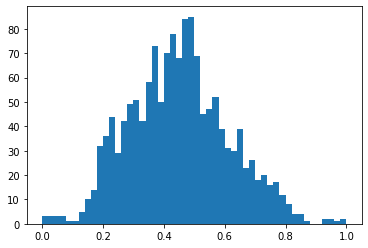

In [30]:
grp = np.log(daily_data.Global_reactive_power)
#scaled_grp = scaleFeatures(grp.values.reshape(-1,1))
scaler = MinMaxScaler()
scaled_grp = scaler.fit_transform(grp.values.reshape(-1,1))
plt.hist(x= scaled_grp, bins=50)
plt.show()

###### ... Sub_metering_1

For this feature i will not perform any transformation because it follows bimodal distriobution. I will just scale the feature to bring it withn a smaller range.

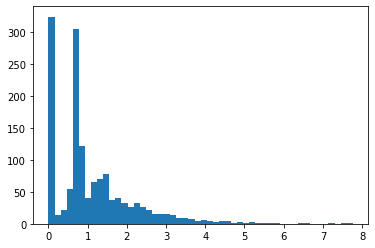

In [31]:
plt.hist(daily_data.Sub_metering_1, bins=50)
plt.show()

In [32]:
scaled_subm1 = daily_data.Sub_metering_1.apply(lambda x: 0 if x<0.5 else 0.5 if x<0.8 else 1)

###### ... Sub_metering_2  

Same approach for feature 'Sub_metering_2'.

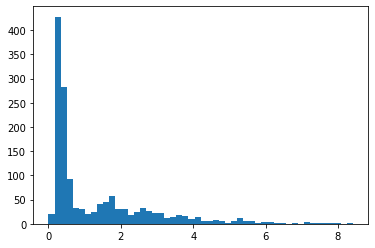

In [33]:
plt.hist(daily_data.Sub_metering_2, bins=50)
plt.show()

In [34]:
scaled_subm2 = daily_data.Sub_metering_2.apply(lambda x: 0 if x<1 else 0.5 if x<2.5 else 1)

###### ... Voltage

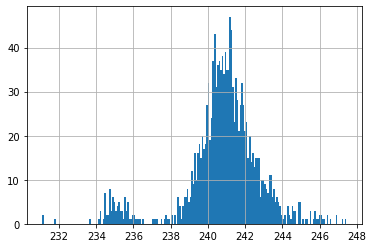

In [35]:
daily_data.Voltage.hist(bins=200)

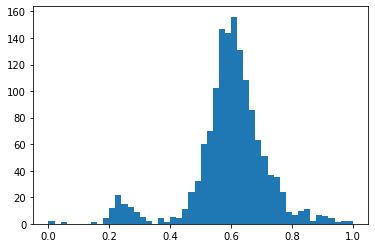

In [36]:
scaler = MinMaxScaler()
scaled_voltage = scaler.fit_transform(daily_data.Voltage.values.reshape(-1,1))
plt.hist(x= scaled_voltage, bins=50)
plt.show()

###### ... Global_active_power

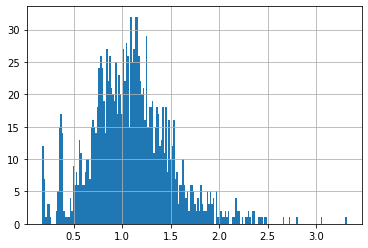

In [37]:
daily_data.Global_active_power.hist(bins=200)

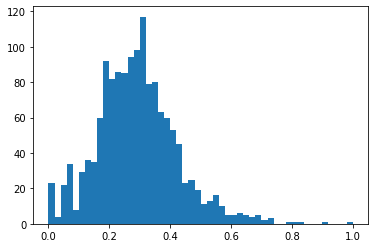

In [38]:
scaler = MinMaxScaler()
scaled_gap = scaler.fit_transform(daily_data.Global_active_power.values.reshape(-1,1))
plt.hist(x= scaled_gap, bins=50)
plt.show()

Lets now replace the old values of features with news values in the dataset.

In [39]:
daily_data['Sub_metering_1'] = scaled_subm1
daily_data['Sub_metering_2'] = scaled_subm2
daily_data['Sub_metering_3'] = scaled_sbm3
daily_data['Sub_metering_4'] = scaled_sbm4
daily_data['Global_intensity'] = scaled_gi
daily_data['Global_reactive_power'] = scaled_grp
daily_data['Voltage'] = scaled_voltage
daily_data['Global_active_power'] = scaled_gap

In [40]:
daily_data.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4
count,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000,1442.000000
mean,0.291813,0.449666,0.596193,0.477220,0.608877,0.287795,0.356382,0.323907
std,0.133065,0.162555,0.125052,0.147236,0.410993,0.393445,0.163906,0.126424
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.204705,0.335632,0.551029,0.397447,0.000000,0.000000,0.240537,0.243838
50%,0.286578,0.446923,0.603771,0.489680,0.500000,0.000000,0.355845,0.320929
75%,0.364274,0.551154,0.659164,0.565658,1.000000,0.500000,0.466878,0.400998
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Train and Test Splitting  

Now i have all features scaled within a range. Next step is to split the dataset into training and testing set. Remember the dataset contains every days total electric consumptions thorughout years. Random splitting with a ration (80:20) wont be desirable because our final goal is to use LSTM model where order of data instances is important. Hence i will use 2010 electric consumption data for Testing the model and rest for training the model.  

Lets check how many instances are there in the year 2010

In [41]:
print('Number of days: ', daily_data['2010'].shape[0])
print('Start Date: ', daily_data['2010'].index[0])
print('End Date: ', daily_data['2010'].index[-1])

Number of days:  330
Start Date:  2010-01-01 00:00:00
End Date:  2010-11-26 00:00:00


In [42]:
daily_data.shape

(1442, 8)

So the year 2010 contains daily electric consumption for 330 days starting from 1st Jan, 2010 to 26th Jan, 2010. Hence last 330 records will be used for testing the model and first (1442 - 330 = 1112) records will be used for training the model. Lets now seperate the training and testing data set.

In [43]:
testing_data = daily_data.iloc[1112:1442 ,: ]
training_data = daily_data.iloc[:1112, :]
print('Shape of Testing Data ', testing_data.shape)
print('Shape of Training Data ', training_data.shape)

Shape of Testing Data  (330, 8)
Shape of Training Data  (1112, 8)


#### Sequence Data Preparation  

Since i am going to build a sequence 2 sequence model, i will now convert the traoning dataset to an input sequences so that these sequences then can be passed to LSTM model as an input.  

The LSTM Encoder-Decoder (Sequence 2 Sequence) model expects an input sequence and returns an output. So i will create the input sequences now. Each sequence will have past 7 days of data. So i can create (1112/7 = 158.85) i.e approx 158 sequences where each sequence contains 7 days of data.  

Splitting training dataset into 158 such arrays each one of which will have 7 days data.  Similar way will split testing dataset into 47 sequences each one of which will have 7 days of records.

In [44]:
# Creating Sequence for Each Week, Where a Week contains 7 days of data for all 8 features
training_data = np.array(np.split(training_data.iloc[6:,:].values, 158))
testing_data = np.array(np.split(testing_data.iloc[:-1,:].values, 47))
print('Training Input Sequence Shape ', training_data.shape)
print('Testing Input Sequence Set Shape ', testing_data.shape)

Training Input Sequence Shape  (158, 7, 8)
Testing Input Sequence Set Shape  (47, 7, 8)


Now i have training input sequence of shape (158, 7, 8) which means 158 sequences each of 7 days data for 8 variables. and testing input sequence of shape (47, 7, 8) which means 47 sequences each of 7 days data for 8 variables.   

The training data sequence is not enough to train LSTM model for better result. Lets do something to increase the number of sequences . I am going to apply below logic to recreate sequences.  

|Input Sequence|Output Sequence|
|--------------|---------------|
|Day1, Day2, Day3, Day4, Day5, Day6, Day7|Day2, Day3, Day4, Day5, Day6, Day7, Day8|
|Day2, Day3, Day4, Day5, Day6, Day7, Day8|Day3, Day4, Day5, Day6, Day7, Day8, Day9|
|Day3, Day4, Day5, Day6, Day7, Day8, Day9|Day4, Day5, Day6, Day7, Day8, Day9, Day10|

In [97]:
data = training_data.reshape(training_data.shape[0]*training_data.shape[1], training_data.shape[2])
inp_lag = 7
inp_start = 0
op_lag = 7
X = []
Y = []

for i in range(data.shape[0]):
    inp_end = inp_start + inp_lag
    input_seq = data[inp_start : inp_end, :]
    
    output_start = inp_end + 1
    output_end = output_start + op_lag
    output_seq = data[output_start:output_end, 0]
    
    if output_end <= len(data):
        X.append(input_seq)
        Y.append(output_seq)
    
    inp_start += 1

X = np.array(X)
Y = np.array(Y)
print('Shape of Input Sequence ', X.shape)
Y = Y.reshape(Y.shape[0], Y.shape[1], 1)
print('Shape of Output Sequence ', Y.shape)

Shape of Input Sequence  (1092, 7, 8)
Shape of Output Sequence  (1092, 7, 1)


Note Output sequence contsins sequence of 7 days but only for single variable which is target variable , hence shape is (1092, 7, 1).  

Now i have 1092 sequences to train LSTM Encoder-Decoder model. Lets build LSTM model

#### Build LSTM Model  

I will train LSTM model passing 3D input of shape (1092, 7, 8). The Encoder Decoder LSTM has two LSTM layers in it. Number of epochs used is 100, batch size is 16. Also i have set the hidden layer size of LSTM layers to 100 neurons.

In [98]:
verbose = 1
epochs = 100
batch_size = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=100, activation='relu'))
model.add(tf.keras.layers.RepeatVector(7))
model.add(tf.keras.layers.LSTM(units=100, activation='relu', return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))


model.compile(loss='mse', optimizer='adam')
history = model.fit(X, Y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.1)

Train on 982 samples, validate on 110 samples
Epoch 1/100
982/982 [==============================] - 4s 4ms/sample - loss: 0.0216 - val_loss: 0.0116
Epoch 2/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0125 - val_loss: 0.0099
Epoch 3/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0117 - val_loss: 0.0094
Epoch 4/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0117 - val_loss: 0.0068
Epoch 5/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0117 - val_loss: 0.0088
Epoch 6/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0114 - val_loss: 0.0071
Epoch 7/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0111 - val_loss: 0.0077
Epoch 8/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0110 - val_loss: 0.0115
Epoch 9/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0111 - val_loss: 0.0076
Epoch 10/100
982/982 [=====

982/982 [==============================] - 1s 1ms/sample - loss: 0.0052 - val_loss: 0.0084
Epoch 80/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0051 - val_loss: 0.0093
Epoch 81/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0051 - val_loss: 0.0087
Epoch 82/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0050 - val_loss: 0.0102
Epoch 83/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0049 - val_loss: 0.0104
Epoch 84/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0049 - val_loss: 0.0099
Epoch 85/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0049 - val_loss: 0.0094
Epoch 86/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0048 - val_loss: 0.0088
Epoch 87/100
982/982 [==============================] - 1s 1ms/sample - loss: 0.0046 - val_loss: 0.0093
Epoch 88/100
982/982 [==============================] - 1s 1ms/sample - loss:

Here is the Traning loss and validation loss plot below. 

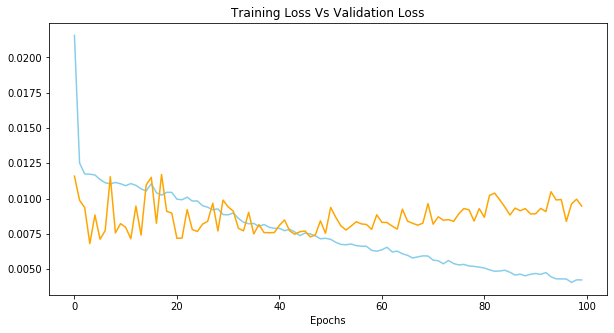

In [99]:
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], color='skyblue')
plt.plot(history.history['val_loss'], color='orange')
plt.title('Training Loss Vs Validation Loss')
plt.xlabel('Epochs')
plt.show()

Now the LSTM model is ready . I will predict the electric consumption for training dataset and for testing data set aswell. Will plot prediction.

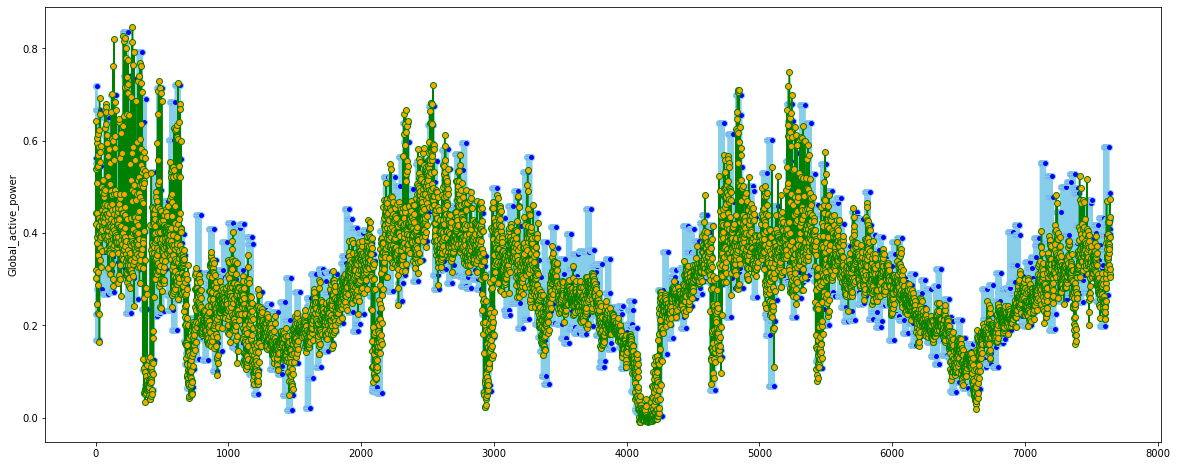

In [100]:
y_train = model.predict(X)
plt.figure(figsize=(20,8))
plt.plot(Y.flatten()[:], marker='o', markerfacecolor='blue', color='skyblue')
plt.plot(y_train.flatten()[:], marker='o', markerfacecolor='orange', color='green')
plt.ylabel('Global_active_power')
plt.show()

I can see model has prediced very well for training dataset. 

Lets predict for test dataset and plot the prediction.

In [101]:
x_test = testing_data[:, :, :]
y_test = testing_data[:, : , 0]
y_pred = model.predict(x_test)
y_actual = y_test.flatten()
y_predicted = y_pred.flatten()

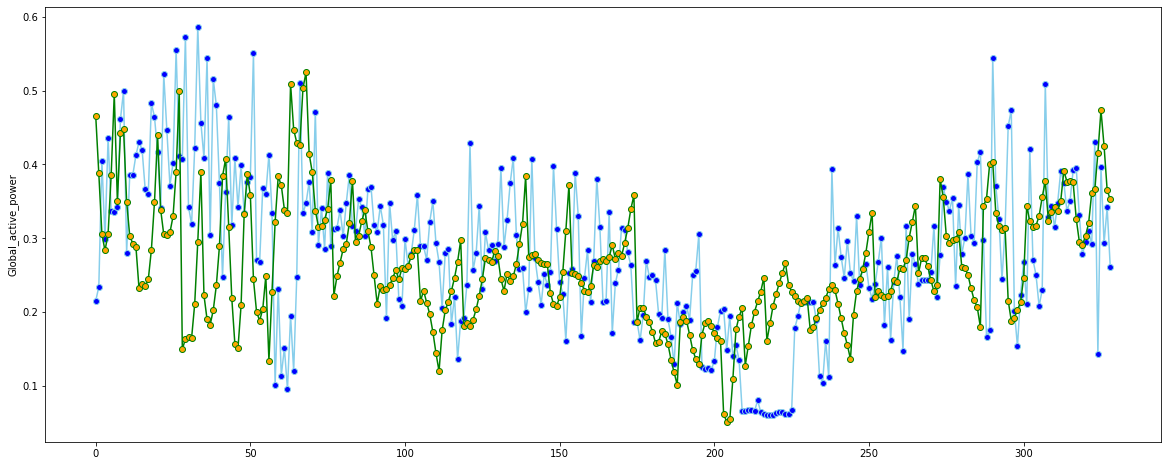

In [102]:
plt.figure(figsize=(20,8))
plt.plot(y_actual[:], marker='o', markerfacecolor='blue', color='skyblue')
plt.plot(y_predicted[:], marker='o', markerfacecolor='orange', color='green')
plt.ylabel('Global_active_power')
plt.show()

Not too bad. Lets show the actual values and predicted values in a dataframe.

In [103]:
pd.DataFrame({
    'Actual Consumption': list(y_actual),
    'Predicted Consumption': list(y_predicted)
})

,Actual Consumption,Predicted Consumption
0,0.215329,0.466198
1,0.234125,0.388019
2,0.405289,0.305767
3,0.299316,0.283534
4,0.435429,0.305819
...,...,...
324,0.143842,0.415169
325,0.396021,0.473415
326,0.293436,0.424992
327,0.341791,0.365207


Lets calculate Mean Squared Error (MSE) of the mdoel. MSE is the squared difference between actual values and target values. The MSE will help to compare between models. 

In [104]:
testing_mse = (sum((y_actual - y_predicted)**2))/len(y_actual)
print('Means Squared Erro of the model is ', testing_mse)

Means Squared Erro of the model is  0.013007603538018338


I have seen model prediction is strongly good for training dataset but not too good for testing dataset. Lets try framing the problem in different way.